Follows from [single_exposure_modeling_test](single_exposure_modeling_test.ipynb) with [spectral_resampling_experiments](spectral_resampling_experiments.ipynb)  to try to speed up the interpolation step.

Most of the tests of the reliability are in those notebooks.

In [2]:
import os
import json
import collections
from pathlib import Path
from multiprocessing import Pool

import numpy as np
from scipy import interpolate, integrate, signal

from tqdm.notebook import tqdm

from astropy.coordinates import SkyCoord
from astropy import table
from astropy import convolution
from astropy import visualization
visualization.quantity_support()
from astropy import units as u
from astropy import constants
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import StdDevUncertainty

import specutils
from specutils import manipulation as specman
from specutils import analysis as specan

from jwst import datamodels

import webbpsf

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
%load_ext Cython

In [3]:
data_dir = Path('widened_2')

test_path = list(data_dir.glob('*04101_00001_nrs2_cal.fits'))
assert len(test_path) == 1
test_path = test_path[0]

test_dm = datamodels.open(test_path)

example_slit = test_dm.slits[50]

## Create the PSF and LSF

In [4]:
wns = webbpsf.NIRSpec()

wns.detector = 'NRS2'
wns.image_mask = 'Single MSA open shutter'

psf = wns.calc_psf(monochromatic=(1.4*u.micron).to(u.meter).value, oversample=10, fov_arcsec=1)

In [5]:
spsf = np.sum(psf['OVERDIST'].data, axis=1)
spsf_offsets = (np.arange(spsf.size) - (spsf.size-1)/2)*psf['OVERDIST'].header['PIXELSCL']*u.arcsec
lsf = np.sum(psf['OVERDIST'].data, axis=0)
lsf_offsets_px = (np.arange(lsf.size) - (lsf.size-1)/2)/4 * u.pixel

In [6]:
dispersion_table = table.Table.read('https://jwst-docs.stsci.edu/files/97979440/97979446/1/1596073265458/jwst_nirspec_g140h_disp.fits', cache=True)
dispersion_table['WAVELENGTH'].unit = u.micron
dispersion_table['DLDS'].unit = u.micron/u.pixel
dispersion_table['R'].unit = u.dimensionless_unscaled
dispersion_table = table.QTable(dispersion_table)
dispersion_table

2023-03-07 16:30:54,768 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/core.py:2097: UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warnings.warn(msg, UnitsWarning)

2023-03-07 16:30:54,770 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/core.py:2097: UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
  warn

WAVELENGTH,DLDS,R
micron,micron / pix,
float32,float32,float32
0.5,0.00024101488816086203,942.9821166992188
0.5013999938964844,0.00024102148017846048,945.5966186523438
0.5027999877929688,0.00024102798488456756,948.2112426757812
0.5041999816894531,0.0002410344168310985,950.8261108398438
0.5055999755859375,0.00024104076146613806,953.441162109375
0.5070000290870667,0.00024104701878968626,956.056396484375
...,...,...
1.8930000066757202,0.00022585173428524286,3809.8203125


In [7]:
wls = np.quantile(example_slit.wavelength[np.isfinite(example_slit.wavelength)], [0, .5,1])*u.micron
dispers_spec = np.interp(wls, dispersion_table['WAVELENGTH'], dispersion_table['DLDS'])
lsf_wl = lsf_offsets_px*dispers_spec[1]

In [8]:
phoenix_model = fits.open('lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte03300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])
spacing = np.min(np.unique(np.diff(phoenix_spec.spectral_axis[msk])))

wl_grid = np.arange(wls[0].value, (wls[-1]+spacing.to(u.micron)).value, spacing.to(u.micron).value)*u.micron

phoenix_sub_spec = specutils.Spectrum1D(spectral_axis=wl_grid, flux=np.interp(wl_grid, phoenix_spec.spectral_axis, phoenix_spec.flux))

2023-03-07 16:30:54,806 - stpipe - WARNING - /usr/local/lib/python3.11/site-packages/astropy/units/format/generic.py:604: UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard
  warnings.warn(



In [9]:
lsf_wl_gridsampled = np.arange(lsf_wl[0].value, (lsf_wl[-1]+spacing.to(u.micron)).value, spacing.to(u.micron).value)*u.micron
lsf_kernel = np.interp(lsf_wl_gridsampled, lsf_wl, lsf)

convolved_phoenix_flux = convolution.convolve_fft(phoenix_sub_spec.new_flux_unit(u.MJy).flux, lsf_kernel)

Now lets check the kernel size to see how much we can decimate

In [10]:
px = np.arange(len(lsf_kernel))
px_cen =  np.sum(lsf_kernel*px)/np.sum(lsf_kernel)
dpx = px - px_cen
px_sig = (np.sum(lsf_kernel*dpx*dpx)/np.sum(lsf_kernel))**0.5
px_sig

118.50371872682383

Factor-of-10 seems perfectly safe then

In [11]:
decimation = 10
convolved_phoenix_spec = specutils.Spectrum1D(spectral_axis=phoenix_sub_spec.spectral_axis[::decimation], flux=convolved_phoenix_flux[::decimation])

In [12]:
%%cython

import numpy as np
cimport cython

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def integrate_spectrum_cy_edgebad(double[::1] model, double[::1] model_wav, double[::1] target_wav_bins):
    assert len(model) == len(model_wav)
    
    cdef Py_ssize_t model_size = model.shape[0]
    
    dwav = np.diff(model_wav)
    cdef double[:] dwav_arr = dwav
    
    resampled = np.zeros(len(target_wav_bins) - 1)
    cdef Py_ssize_t resampled_size = target_wav_bins.shape[0] - 1
    cdef double[::1] resampled_arr = resampled
    
    cdef double lower_wave = 0
    cdef double upper_wave = 0
    cdef Py_ssize_t lower_mindex = 0
    cdef Py_ssize_t upper_mindex = 0
    
    cdef Py_ssize_t i, j
    
    for i in range(resampled_size):
        lower_wave = target_wav_bins[i]
        upper_wave = target_wav_bins[i+1]
    
        for j in range(model_size):
            if model_wav[j] > lower_wave:
                lower_mindex = j
                break
                
        for j in range(lower_mindex, model_size):
            if model_wav[j] > upper_wave:
                upper_mindex = j -1  # this -1 might not be right
                break
                
        # TODO: deal with the edge pixels properly
                
        for j in range(lower_mindex, upper_mindex):
            resampled_arr[i] += dwav_arr[j] * model[j]

    return resampled

## Checking how tilted the wavelengths are for possible simplification

In [13]:
yg, xg = np.meshgrid(*[np.arange(s) for s in example_slit.data.shape[::-1]])
lower_wl = example_slit.meta.wcs.pixel_to_world(yg-.5, xg-.5)[1]
upper_wl = example_slit.meta.wcs.pixel_to_world(yg+.5, xg+.5)[1]
mid_wl = (lower_wl+upper_wl)/2

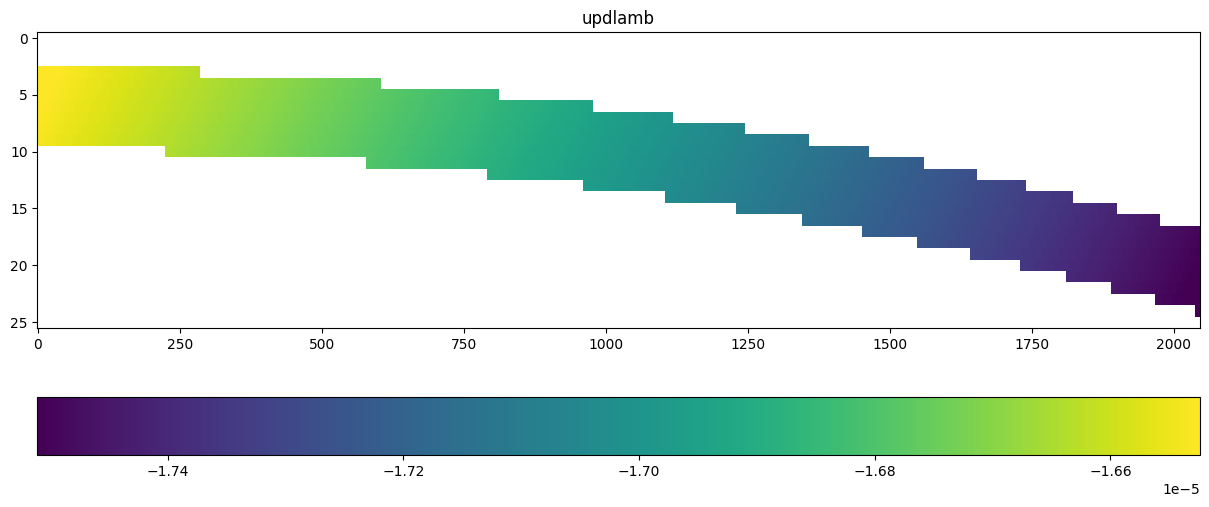

In [14]:
plt.figure(figsize=(15, 6))
dlamb = signal.convolve2d(mid_wl.value, [[0,1,0],
                                            [0,-1,0],
                                            [0,0,0]], mode='valid')
visualization.imshow_norm(dlamb, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.title('updlamb')
plt.colorbar(orientation='horizontal')

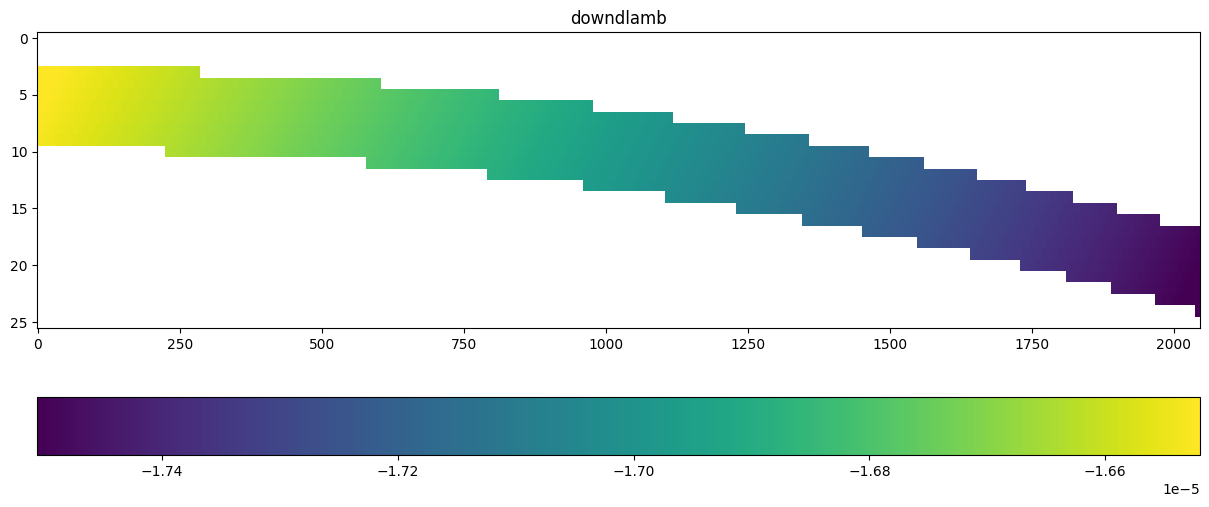

In [15]:
plt.figure(figsize=(15, 6))
dlamb = signal.convolve2d(mid_wl.value, [[0,0,0],
                                            [0,1,0],
                                            [0,-1,0]], mode='valid')
visualization.imshow_norm(dlamb, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.title('downdlamb')
plt.colorbar(orientation='horizontal')

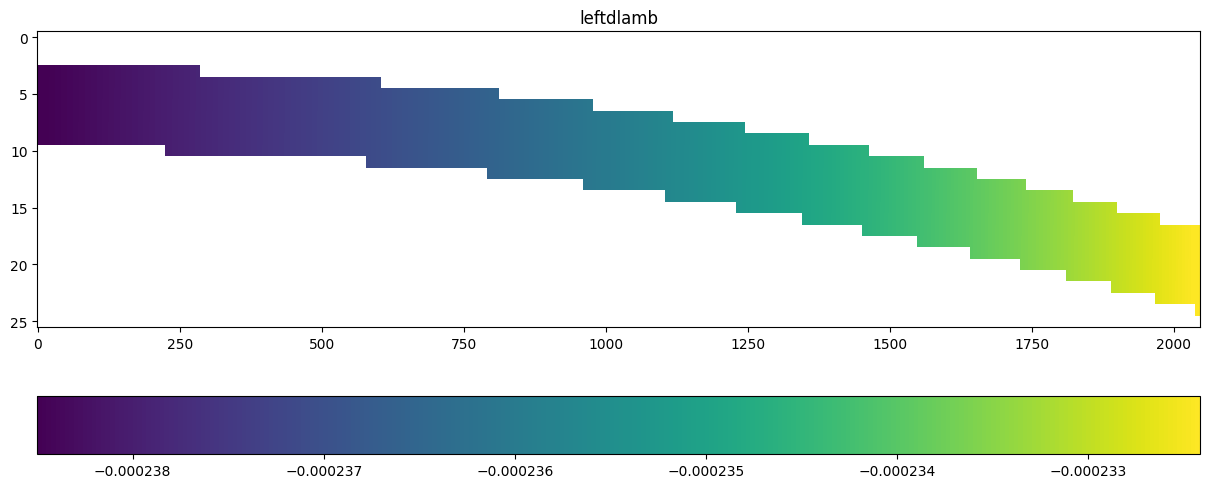

In [16]:
plt.figure(figsize=(15, 6))

dlamb = signal.convolve2d(mid_wl.value, [[0,0,0],
                                         [-1,1,0],
                                         [0,0,0]], mode='valid')
visualization.imshow_norm(dlamb, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.title('leftdlamb')
plt.colorbar(orientation='horizontal')

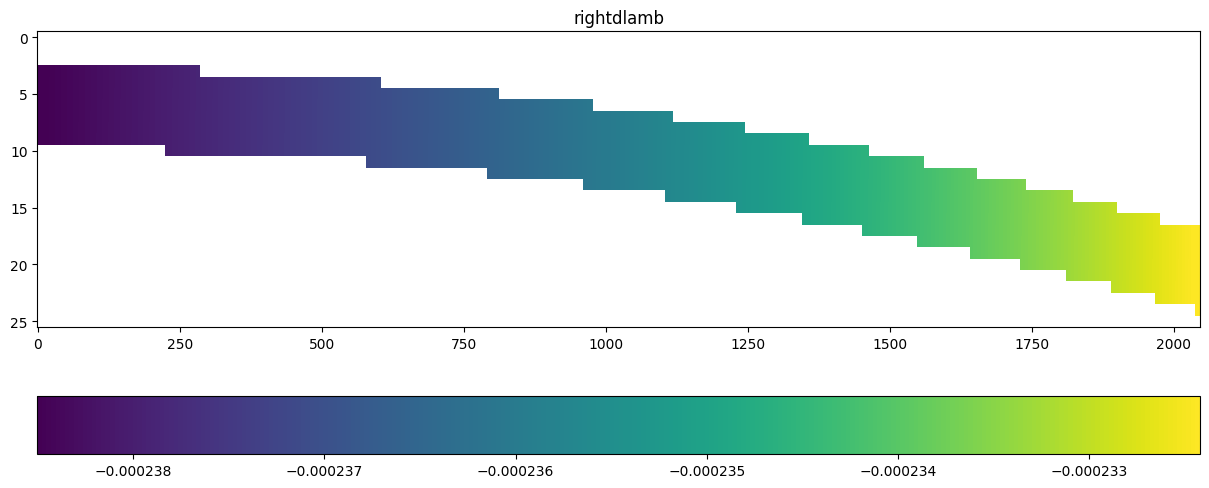

In [17]:
plt.figure(figsize=(15, 6))

dlamb = signal.convolve2d(mid_wl.value, [[0,0,0],
                                         [0,-1,1],
                                         [0,0,0]], mode='valid')
visualization.imshow_norm(dlamb, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.title('rightdlamb')
plt.colorbar(orientation='horizontal')

So the dispersion-direction shift is ~10x per pixel more than the spatial direction.  And since the spatial size is ~5 px, this effect is pretty small over the whole spectrum (vertical shift is half one single horizontal pixel).  Not necessarily completely ignorable, but ignorable for a first go, hopefull.  How wrong are we if we do that?

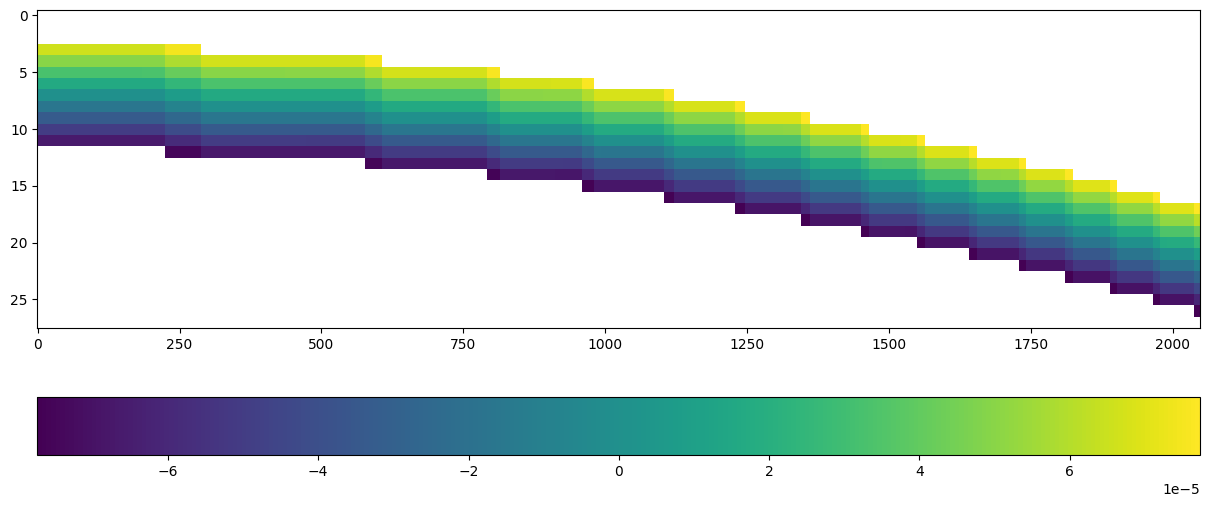

In [18]:
mean_wl = np.nanmean(mid_wl, axis=0)
diffwl = mid_wl - (np.ones(mid_wl.shape[0])[:, np.newaxis] * mean_wl)

plt.figure(figsize=(15, 6))
visualization.imshow_norm(diffwl.to(u.um).value, aspect=20,
                          interval=visualization.PercentileInterval(99),
                          stretch=visualization.LinearStretch(),
                          interpolation='nearest')
plt.colorbar(orientation='horizontal')

## Probabilistic model

In [19]:
import emcee
import corner

In [20]:
MINF = -np.inf

class SlitProbModel:
    param_names = ['spatial_offset_arcsec','v_kms', 'spec_to_model_normalization']
    
    def __init__(self, slitdatanode, model_1d_spectrum):
        self._cached_model = None
        self.slitdata_node = slitdatanode
        self.model_1d_spectrum = model_1d_spectrum
        
        self.spatial_offset_arcsec = 0
        self.v_kms = 0
        self.spec_to_model_normalization = 1
        
        self.sm_ratio_pri_bounds = (0.5, 1.5)
    
    def update_params(self, params):
        self._cached_model = None
        
        if len(params) != len(self.param_names):
            raise ValueError('params does not match param_names!')
            
        for nm, p in zip(self.param_names, params):
            setattr(self, nm, p)
            
    @property
    def slitdata_node(self):
        return self._slitdata_node
    
    @slitdata_node.setter
    def slitdata_node(self, val):
        self._slitdata_node = val
        self._notnan_mask = ~np.isnan(val.data)
        self._err_mask = val.err>0
        self._data_mask = self._notnan_mask & self._err_mask
        
        self._masked_data = val.data[self._data_mask]
        self._masked_err = val.err[self._data_mask]
        self._slit_coo = SkyCoord(val.source_ra, val.source_dec, unit=u.deg)

        
        self._loglike_norm = -0.5*np.log(2*np.pi) - np.log(self._masked_err)
        self._cached_model = None
            
    @property
    def model_1d_spectrum(self):
        return self._model_1d_spectrum
    
    @model_1d_spectrum.setter
    def model_1d_spectrum(self, val):
        self._model_1d_spectrum = val
        self._model_1d_contiguous_flux = np.ascontiguousarray(val.flux.value)
        self._model_1d_contiguous_spectral_axis = np.ascontiguousarray(val.spectral_axis.value)
        self._cached_model = None

    def make_model_spectrum(self):
        if self._cached_model is None:
            yg, xg = np.meshgrid(*[np.arange(s) for s in self._slitdata_node.data.shape[::-1]])
            data_coo, data_wl = self._slitdata_node.meta.wcs.pixel_to_world(yg, xg)
            data_sep = self._slit_coo.separation(data_coo)

            wcs_valid = np.isfinite(data_coo.ra)&np.isfinite(data_wl)

            sep_sign = 1 - (xg > np.nanargmin(data_sep, axis=0))*2
            data_sep *= sep_sign

            model_image = np.interp(data_sep + self.spatial_offset_arcsec*u.arcsec, 
                                    spsf_offsets, spsf)

            yg1, xg1 = np.meshgrid(*[np.arange(s + 1) for s in self._slitdata_node.data.shape[::-1]])
            dlolp1 = self.v_kms/constants.c.to(u.km/u.s).value + 1
            bin_wl = self.slitdata_node.meta.wcs.pixel_to_world(yg1-.5, xg1-.5)[1] * dlolp1
            bin_wl_mean = np.nanmean(bin_wl, axis=0)
            
            integrated_spec_model = integrate_spectrum_cy_edgebad(self._model_1d_contiguous_flux , self._model_1d_contiguous_spectral_axis, bin_wl_mean)
            
            self._cached_model = integrated_spec_model * model_image * self.spec_to_model_normalization
        return self._cached_model
    
    def _imshow_something(self, something, **plotkwargs):
        plotkwargs.setdefault('aspect', something.shape[1]/something.shape[0]/3)
        plotkwargs.setdefault('interval', visualization.PercentileInterval(99))
        plotkwargs.setdefault('stretch', visualization.LinearStretch())
        plotkwargs.setdefault('interpolation', 'nearest')
        
        return visualization.imshow_norm(something, **plotkwargs)
    
    def imshow_model(self, **plotkwargs):
        return self._imshow_something(self.make_model_spectrum())
    
    def imshow_data(self, **plotkwargs):
        return self._imshow_something(self.slitdata_node.data)
    
    def imshow_residual(self, **plotkwargs):
        return self._imshow_something(self.slitdata_node.data - self.make_model_spectrum())
        
    def log_prior(self):
        if self.spatial_offset_arcsec*self.spatial_offset_arcsec > 1:
            return MINF
        if self.v_kms > 500 or self.v_kms < -500:
            return MINF
        if self.spec_to_model_normalization > self.sm_ratio_pri_bounds[1] or self.spec_to_model_normalization < self.sm_ratio_pri_bounds[0]:
            return MINF
        return 0

    def log_likelihood(self):
        model = self.make_model_spectrum()
        
        d = model[self._data_mask] - self.slitdata_node.data[self._data_mask]        
        return self._loglike_norm + -0.5*(d/example_slit.err[self._data_mask])**2

    def log_prob(self, params):
        self.update_params(params)
        
        lpri = self.log_prior()
        if lpri == MINF:
            return MINF

        return np.nansum(lpri + self.log_likelihood())
    
    def make_sampler_and_inits(self, nwalkers, stds, **kwargs):
        sampler = emcee.EnsembleSampler(nwalkers, len(self.param_names), self.log_prob, **kwargs)
        
        try:
            stds = float(stds)
        except TypeError:
            pass
        else:
            stds = [stds for _ in range(len(self.param_names))]
            
        state0 = emcee.utils.sample_ball([getattr(self, nm) for nm in self.param_names], 
                                         stds, 
                                         nwalkers)
        
        return sampler, state0
    
    def estimate_normalization_from_quantile(self, quantile=.99, pri_bounds_fraction=[.5, 2]):
        self.spec_to_model_normalization = 1
        self._cached_model = None
        
        data_quantile = np.nanquantile(self.slitdata_node.data, quantile)
        model_quantile = np.nanquantile(self.make_model_spectrum(), quantile)
        spec_to_model_normalization = data_quantile/model_quantile
        if pri_bounds_fraction is not None:
            self.sm_ratio_pri_bounds = np.array(pri_bounds_fraction) * spec_to_model_normalization
        self._cached_model = None
        self.spec_to_model_normalization = spec_to_model_normalization
        
        return data_quantile, model_quantile
        
        
    
    def make_and_run_sampler(self, nwalkers, stds, nsteps, **kwargs):
        prog = kwargs.pop('progress', None)
        sampler, state0 = self.make_sampler_and_inits(nwalkers, stds, **kwargs)
        sampler.run_mcmc(state0, nsteps, progress=prog)
        return sampler
    
    def plot_chains(self, sampler):
        fig, axs = plt.subplots(len(self.param_names), sharex=True, figsize=(12, 3*len(self.param_names)))
        for c, nm, ax in zip(sampler.chain.T, self.param_names, axs.ravel()):
            ax.plot(c)
            ax.set_ylabel(nm)
            
    def plot_corner(self, sampler, quantiles=[.1,.5,.9], **kwargs):
        kwargs.setdefault('show_titles', True)
        kwargs.setdefault('labels', self.param_names)
        kwargs.setdefault('quantiles', [.1,.5,.9])
        corner.corner(sampler.flatchain, **kwargs)
        

spm = SlitProbModel(example_slit, model_1d_spectrum=convolved_phoenix_spec)

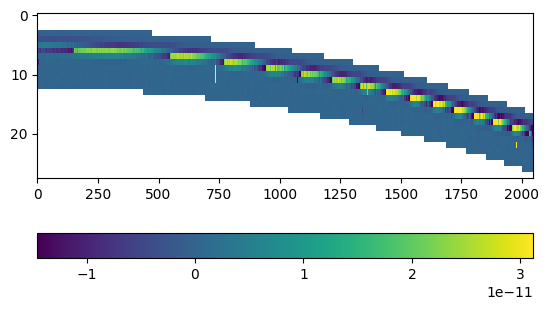

In [21]:
spm.update_params([0.03, -100, 1]) # starting offset guess
spm.estimate_normalization_from_quantile()

spm.imshow_residual()
plt.colorbar(orientation='horizontal')

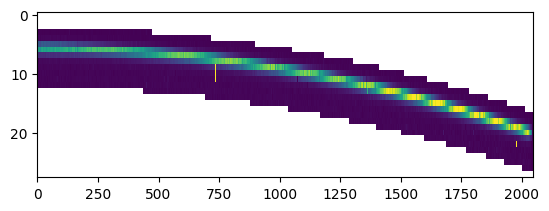

In [29]:
spm.imshow_data();

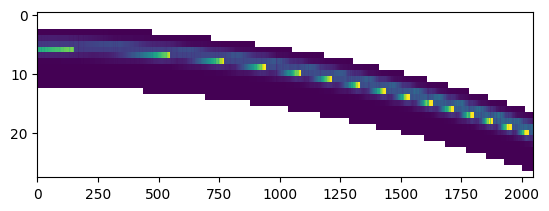

In [23]:
spm.imshow_model();

100%|█████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]
2023-03-06 22:37:51,022 - stpipe - WARNING - Too few points to create valid contours


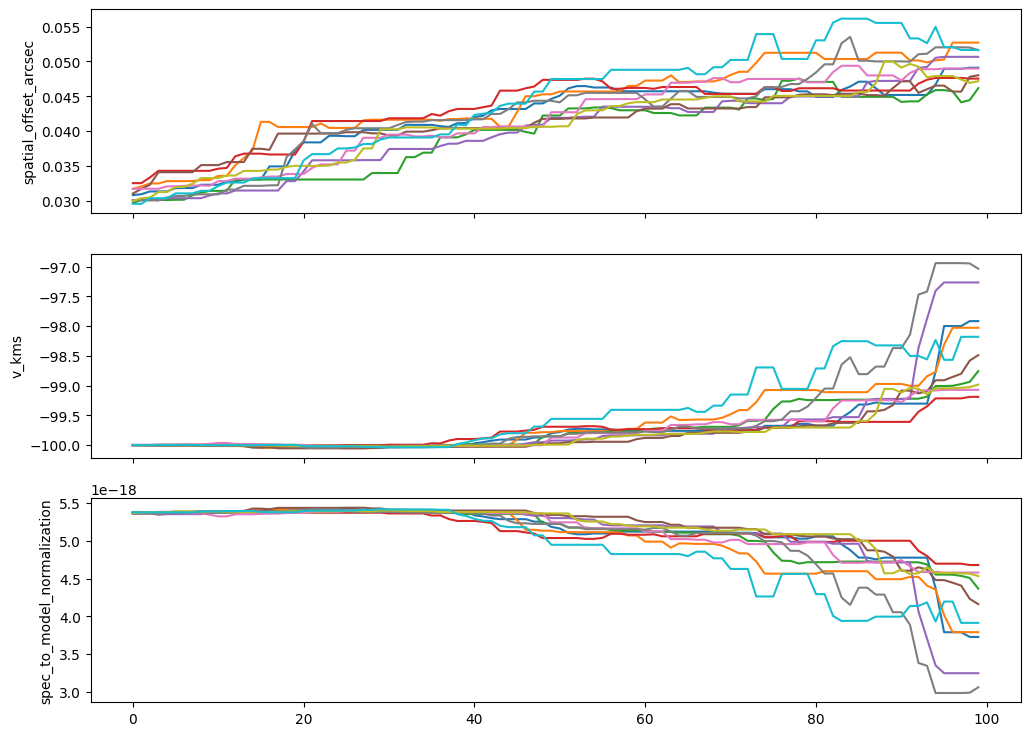

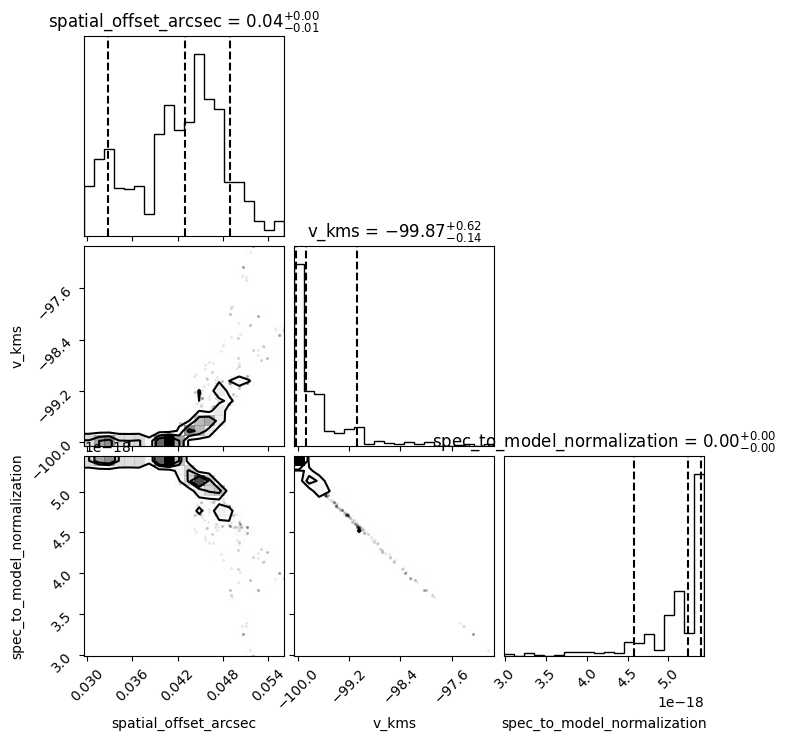

In [338]:
sampler = spm.make_and_run_sampler(10, [1e-3, 1e-3, spm.spec_to_model_normalization*1e-3], 100, progress=True)
spm.plot_chains(sampler)
spm.plot_corner(sampler)

OK that model is nonesense. What's up here?

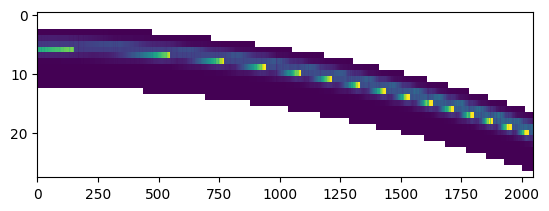

In [24]:
spm.update_params([0.03, -100, 1]) # starting offset guess
spm.estimate_normalization_from_quantile()
spm.imshow_model();

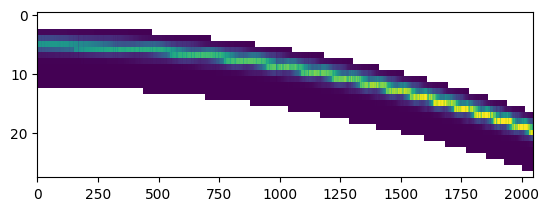

In [25]:
spm.update_params([0.0, -100, 1]) # starting offset guess
spm.estimate_normalization_from_quantile()
spm.imshow_model();

Hmm, so something clearly wrong with the way we're handling the PSF part...

(-0.5, 0.5)

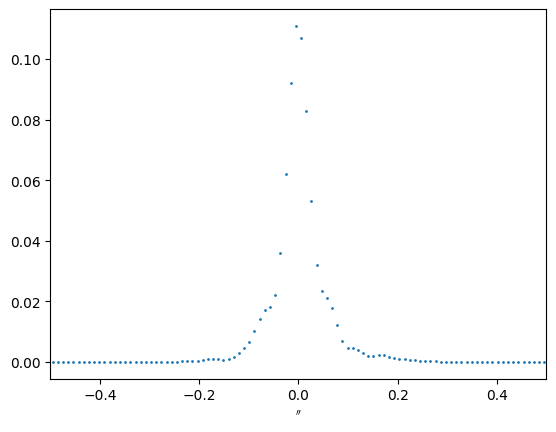

In [26]:
plt.plot(spsf_offsets, spsf, '.', ms=2)
plt.xlim(-.5, .5)

Well there's the issue - linear interpolation is nowhere close to good enough.  Need to use an improved version of the integral with proper edge support.

In [56]:
%%cython --annotate

import numpy as np
cimport cython

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def integrate_samples_cy(double[::1] model, double[::1] model_x, double[::1] target_x_bins_lower, double[::1] target_x_bins_upper):
    """
    Assumptions: model_x is sorted low to high, model/model_x match in size, target_x_bins dont fall off the edges of model_x.  Might segfault if this is not respected...
    """
    assert len(model) == len(model_x)
    
    cdef Py_ssize_t model_size = model.shape[0]
    
    resampled = np.zeros(len(target_x_bins_lower))
    cdef Py_ssize_t resampled_size = resampled.shape[0]
    cdef double[::1] resampled_arr = resampled
    
    cdef double lower_x = 0
    cdef double upper_x = 0
    cdef Py_ssize_t lower_mindex = 0
    cdef Py_ssize_t upper_mindex = 0
    
    cdef Py_ssize_t i, j
    
    cdef double dx = 0;
    cdef double xmid = 0;
    
    for i in range(resampled_size):
        lower_x = target_x_bins_lower[i]
        upper_x = target_x_bins_upper[i]
    
        for j in range(model_size):
            if model_x[j] > lower_x:
                lower_mindex = j
                break
                
        for j in range(lower_mindex, model_size):
            if model_x[j] > upper_x:
                upper_mindex = j
                break
            
        for j in range(lower_mindex, upper_mindex):
            dx = (model_x[j+1] - model_x[j-1]) / 2
            resampled_arr[i] += dx * model[j]
                
    return resampled
        
#         # remove right pixel past end of right edge
#         xmid = 0.5*(model_x[upper_mindex - 1] + model_x[upper_mindex])
#         # if upper_x > xmid:
#         #     resampled_arr[i] += (upper_x - xmid) * model[upper_mindex]
#         # else:
#         #     resampled_arr[i] -= (xmid - upper_x) * model[upper_mindex - 1]
#         resampled_arr[i] += (upper_x - xmid) * model[upper_mindex - (upper_x < xmid)]
#         # remove left pixel past left edge
#         xmid = 0.5*(model_x[lower_mindex - 1] + model_x[lower_mindex])
#         resampled_arr[i] += (xmid - lower_x) * model[lower_mindex - (lower_x < xmid)]
            
#         #TODO: add the "triangle" for the linear interpolation instead of box case
        

#     return resampled

Further optimizations possible:
* Pre-compute the model dx's, although they need some updating for 1+z rescaling sometimes

Now just do a quick test run to see if there's a difference in run time

In [35]:
yg1, xg1 = np.meshgrid(*[np.arange(s + 1) for s in spm._slitdata_node.data.shape[::-1]])
bin_wl = spm.slitdata_node.meta.wcs.pixel_to_world(yg1-.5, xg1-.5)[1]
bin_wl_mean = np.nanmean(bin_wl, axis=0)

%timeit integrate_spectrum_cy_edgebad(spm._model_1d_contiguous_flux , spm._model_1d_contiguous_spectral_axis, bin_wl_mean)
%timeit integrate_samples_cy(spm._model_1d_contiguous_flux, spm._model_1d_contiguous_spectral_axis, bin_wl_mean[:-1], bin_wl_mean[1:])

# now a run that's ~ the size of the PSF
fake_y = np.random.randn(100)
fake_x = np.linspace(0, 1000/2., 100).astype(float)
fake_samplesl = np.arange(1000)/3000.
fake_samplesu = np.arange(1000)/2000.
%timeit integrate_samples_cy(spm._model_1d_contiguous_flux , spm._model_1d_contiguous_spectral_axis, fake_samplesl, fake_samplesu)

9.51 ms ± 7.14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.28 ms ± 4.65 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
71.3 µs ± 484 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [75]:
mms = spm.make_model_spectrum()
mms.shape

(29, 2049)

In [79]:
 np.nanargmin(mms[:,:-1], axis=0).shape

(2048,)

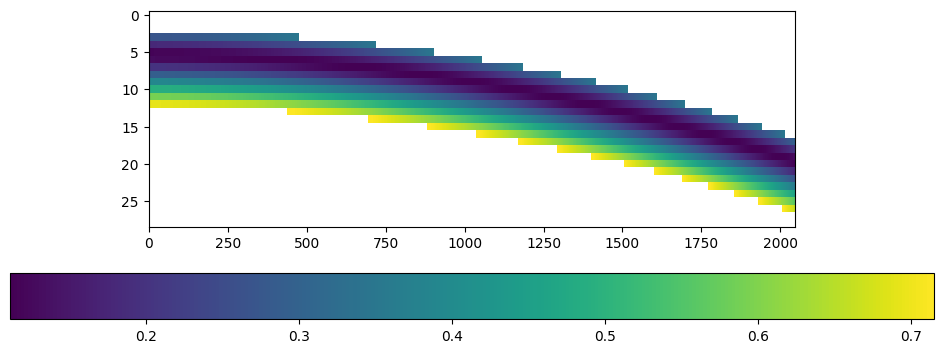

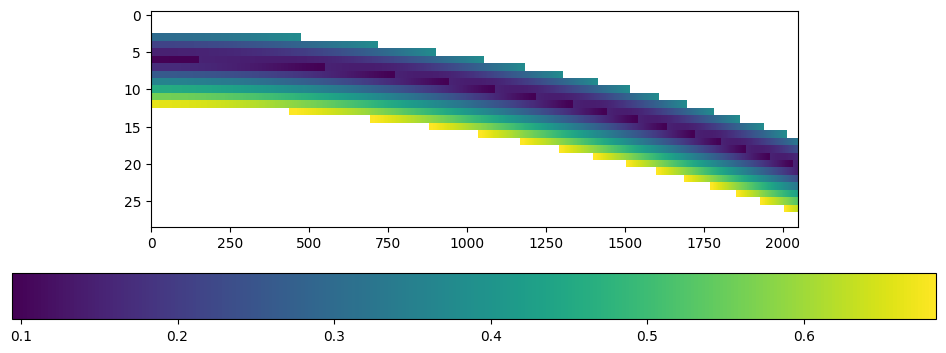

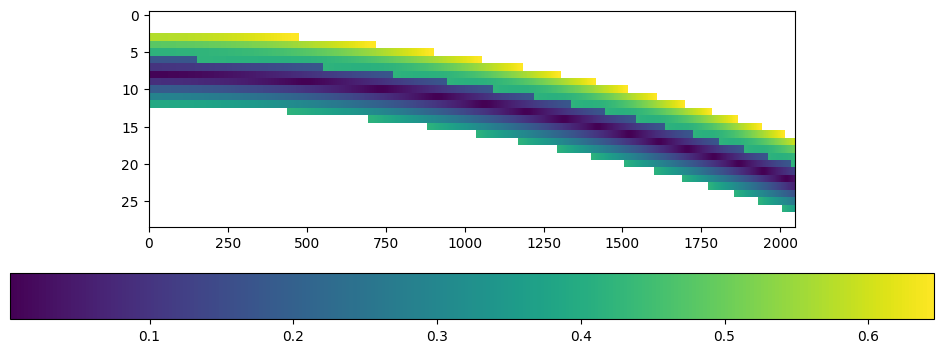

In [98]:
class FixedSlitProbModel(SlitProbModel):
    def make_model_spectrum(self):
        if self._cached_model is None:
            yg1, xg1 = np.meshgrid(*[np.arange(s + 1) for s in self._slitdata_node.data.shape[::-1]])
            data_coo, data_wl = self._slitdata_node.meta.wcs.pixel_to_world(yg1[:, :-1], xg1[:, :-1])
            
            data_sep_asec = self._slit_coo.separation(data_coo).arcsec
            sep_sign = 1 - (xg1[:, :-1] > np.nanargmin(data_sep_asec, axis=0))*2
            data_sep_asec *= sep_sign
            data_sep_asec += self.spatial_offset_arcsec

            model_image = integrate_samples_cy(spsf, spsf_offsets, data_sep_asec[1:, 1:].ravel(), data_sep_asec[:-1, :-1].ravel()).reshape((data_sep_asec.shape[0]-1, data_sep_asec.shape[1]-1))
            #model_image = np.ones((data_sep.shape[0]-1, data_sep.shape[1]-1), dtype=float)

            dlolp1 = self.v_kms/constants.c.to(u.km/u.s).value + 1
            bin_wl = data_wl * dlolp1
            bin_wl_mean = np.nanmean(bin_wl, axis=0)
            
            integrated_spec_model = integrate_samples_cy(self._model_1d_contiguous_flux, self._model_1d_contiguous_spectral_axis, bin_wl_mean[:-1], bin_wl_mean[1:])
            
            self._cached_model = integrated_spec_model * model_image * self.spec_to_model_normalization
            self._cached_model =  model_image * self.spec_to_model_normalization
            self._cached_model = np.abs(data_sep_asec)
        return self._cached_model
    
spm = FixedSlitProbModel(example_slit, model_1d_spectrum=convolved_phoenix_spec)

plt.figure(figsize=(15, 4))
spm.update_params([0,-100,1])
spm.estimate_normalization_from_quantile()
spm.imshow_model()
plt.colorbar(orientation='horizontal')

plt.figure(figsize=(15, 4))
spm.update_params([0.03,-100,1])
spm.estimate_normalization_from_quantile()
spm.imshow_model()
plt.colorbar(orientation='horizontal')

plt.figure(figsize=(15, 4))
spm.update_params([0.3,-100,1])
spm.estimate_normalization_from_quantile()
spm.imshow_model()
plt.colorbar(orientation='horizontal');

Hmm.  Lets take a step back and rethink how we're doing this. Continued in [single_exposure_modeling_convolution]([single_exposure_modeling_convolution].ipynb)